In [289]:

import importlib
import data_prep as dp
import macro_utils
import pandas as pd
importlib.reload(dp)
importlib.reload(macro_utils)
print(dir(dp))  # Check if functions appear now
import matplotlib.pyplot as plt

Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [3]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

In [290]:
df = pd.read_csv('./../data/Sentiment Macro 7Y News 2.5K Cap.csv')

In [291]:
df.index = pd.to_datetime(df['date'])

In [292]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

df = macro_utils.calculate_stats(df)
df.head()



,Unnamed: 0,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,overall_pos_count,overall_neg_count,vix_target,mean_sentiment_decay,shock_pos,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore
date,,,,,,,,,,,,,,,,,,,,,
2017-08-13,29,2017-08-13,0.091027,0.091027,0.091027,1,0,0.092476,0.092476,0.092476,...,2,0,12.33,0.060276,0.091751,0.091751,1,0,0.179904,0.565134
2017-08-18,30,2017-08-18,0.091053,0.091053,0.091053,1,0,0.086394,0.086394,0.086394,...,2,0,14.26,0.091751,0.088724,0.088724,1,0,0.403543,1.606260
2017-08-19,31,2017-08-19,0.081515,0.081515,0.081515,1,0,0.081813,0.081813,0.081813,...,2,0,13.19,0.088724,0.081664,0.081664,1,0,0.332323,1.192475
2017-08-29,32,2017-08-29,-0.289383,-0.648128,0.069362,1,1,-0.271747,-0.618465,0.074970,...,2,2,11.70,0.081664,0.072166,-0.633296,0,0,0.057866,0.384139
2017-08-31,33,2017-08-31,0.873115,0.873115,0.873115,1,0,0.082140,0.082140,0.082140,...,2,0,10.59,-0.280565,0.477627,0.477627,1,0,-0.052773,-0.283813


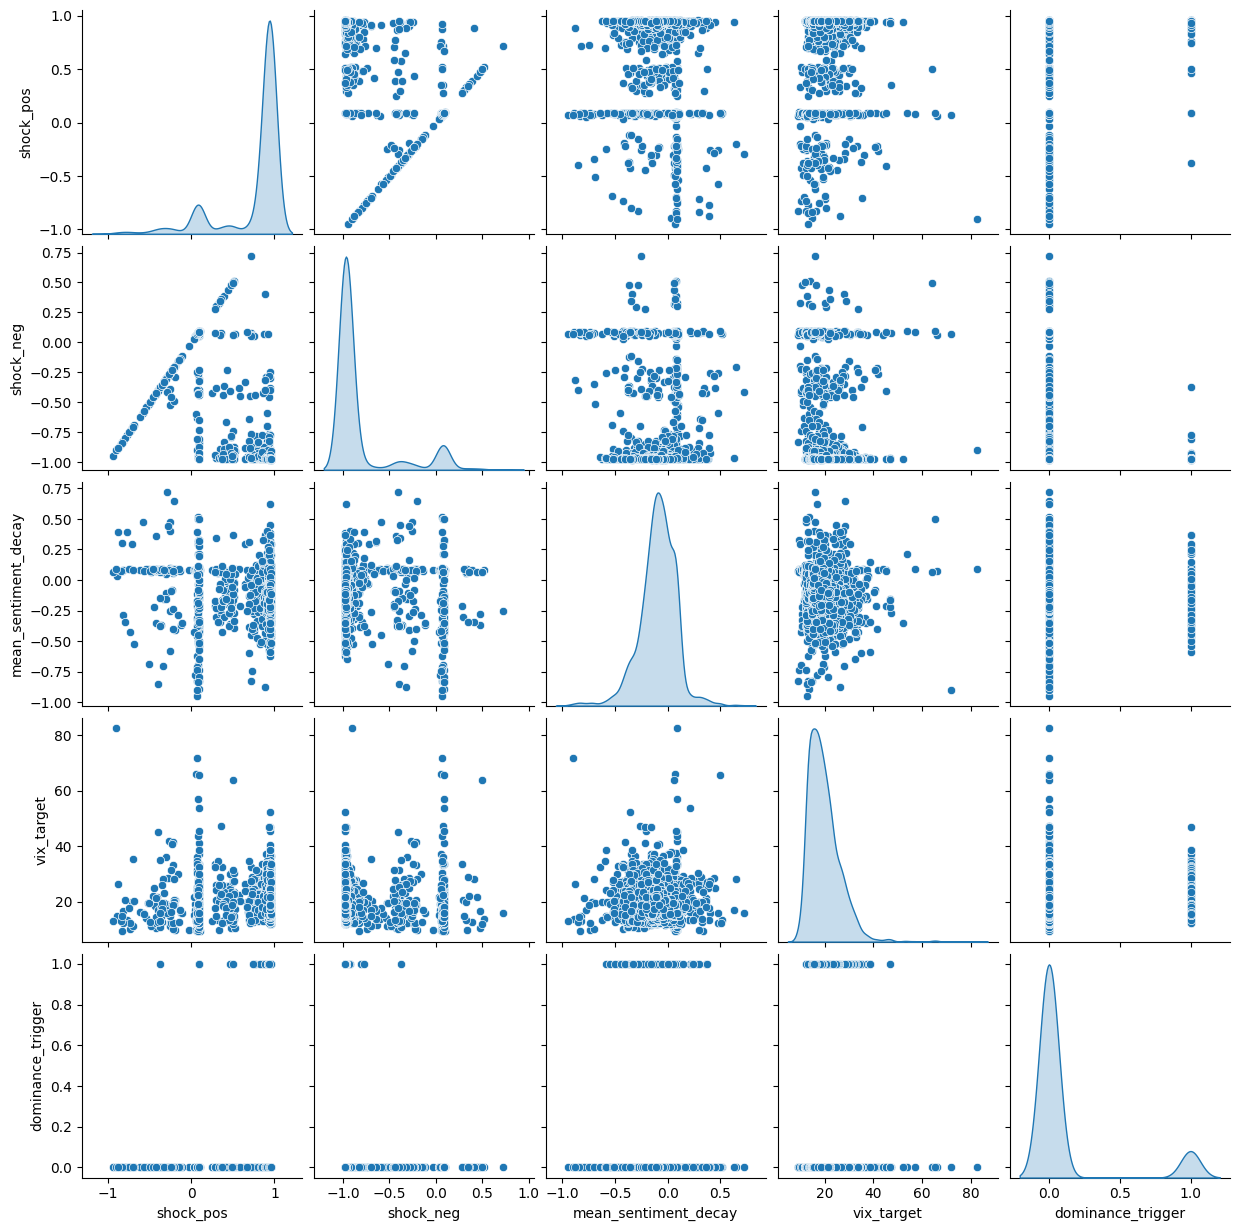

In [293]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target', 'dominance_trigger'], diag_kind='kde')


In [294]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]
selected_features = feature_sets[0]

In [295]:

df.index = pd.to_datetime(df.index)

# Train: Post-COVID to end of 2023
train_df = df[(df.index >= "2020-06-01") & (df.index <= "2023-12-31")]
# Test: Recent years
test_df = df[df.index >= "2024-01-01"]
print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

df_model = train_df.dropna(subset=feature_sets[0] + ['vix_target']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_target']


Train set: 1204 rows
Test set: 458 rows


In [296]:
transition_matrix, results, df_model = macro_utils.regime_t_markov_model(X, y, df_model)

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


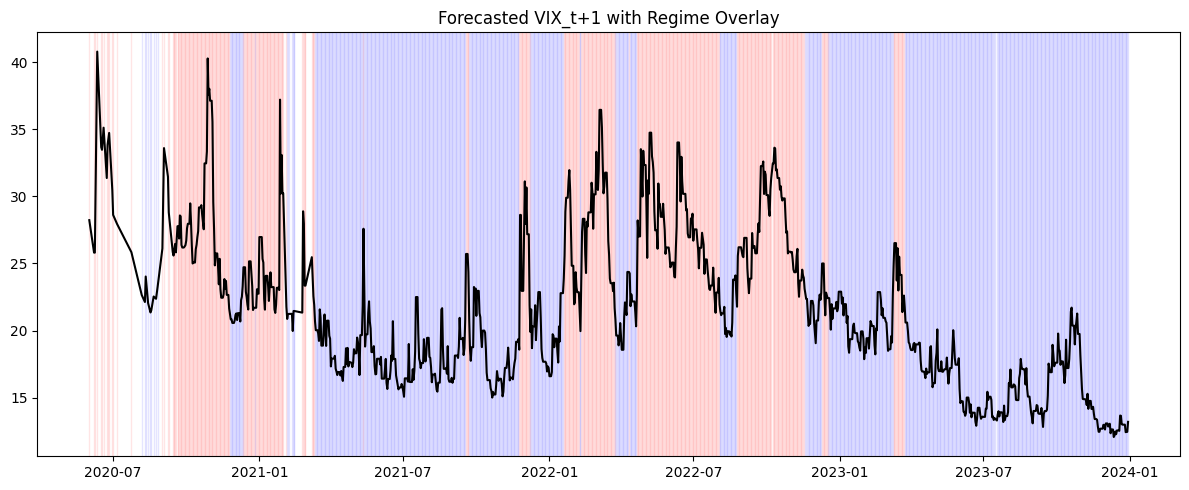

In [297]:
import matplotlib.pyplot as plt #graph vix t+1 with regime overlay

plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model['vix_target'], label='VIX_t', color='black')

for i in range(len(df_model)):
    color = 'red' if df_model['regime_t+1'].iloc[i] == 1 else 'blue'
    plt.axvspan(df_model.index[i], df_model.index[i], color=color, alpha=0.1)

plt.title('Forecasted VIX_t+1 with Regime Overlay')
plt.tight_layout()
plt.show()


In [298]:
df_model.head()

,Unnamed: 0,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,shock_pos,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,regime_t,regime_t_raw,regime_t+1,regime_t+1_raw
date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,293,2020-06-01,0.092641,0.092641,0.092641,1,0,0.092438,0.092438,0.092438,...,0.092540,0.092540,1,0,-0.505431,-0.674382,1,0.867443,1.0,0.896374
2020-06-07,294,2020-06-07,0.088074,0.088074,0.088074,1,0,0.087048,0.087048,0.087048,...,0.087561,0.087561,1,0,-0.429487,-0.854666,1,0.896374,1.0,0.975543
2020-06-08,295,2020-06-08,-0.248316,-0.910594,0.089416,2,1,0.078985,0.055655,0.091886,...,0.090651,-0.427470,1,0,-0.380610,-0.900085,1,0.975543,1.0,1.000000
2020-06-11,296,2020-06-11,0.052232,0.052232,0.052232,1,0,-0.510630,-0.510630,-0.510630,...,-0.229199,-0.229199,1,0,-0.009230,-0.054633,1,1.000000,1.0,0.999974
2020-06-16,297,2020-06-16,0.084131,0.084131,0.084131,2,0,0.092482,0.092482,0.092482,...,0.088306,0.088306,2,0,-0.231805,-0.559804,1,0.999974,1.0,0.999970


In [299]:
clf, y_pred, classification_df = macro_utils.clf_panic_tomorrow(df_model, selected_features, 'regime_t+1')

              precision    recall  f1-score   support

         0.0       0.69      0.99      0.81       761
         1.0       0.92      0.22      0.35       442

    accuracy                           0.71      1203
   macro avg       0.80      0.60      0.58      1203
weighted avg       0.77      0.71      0.64      1203



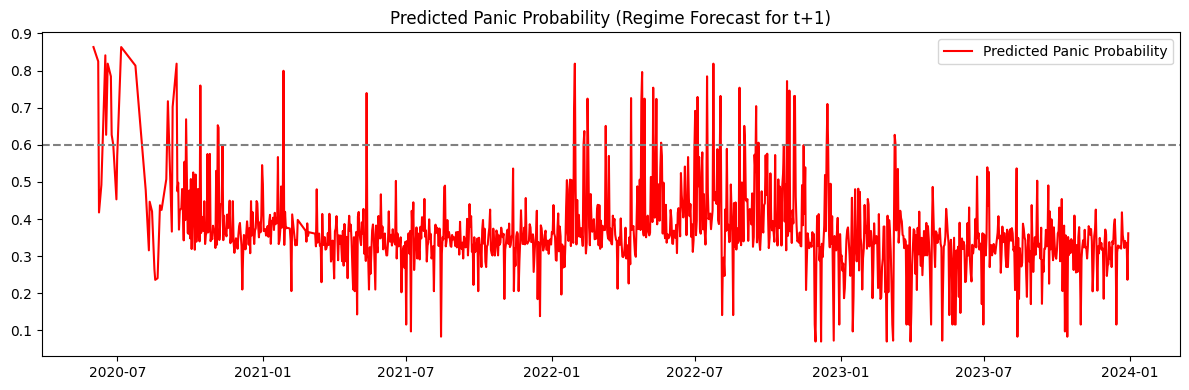

In [300]:
plt.figure(figsize=(12, 4))
plt.plot(df_model.index, df_model['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.6, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


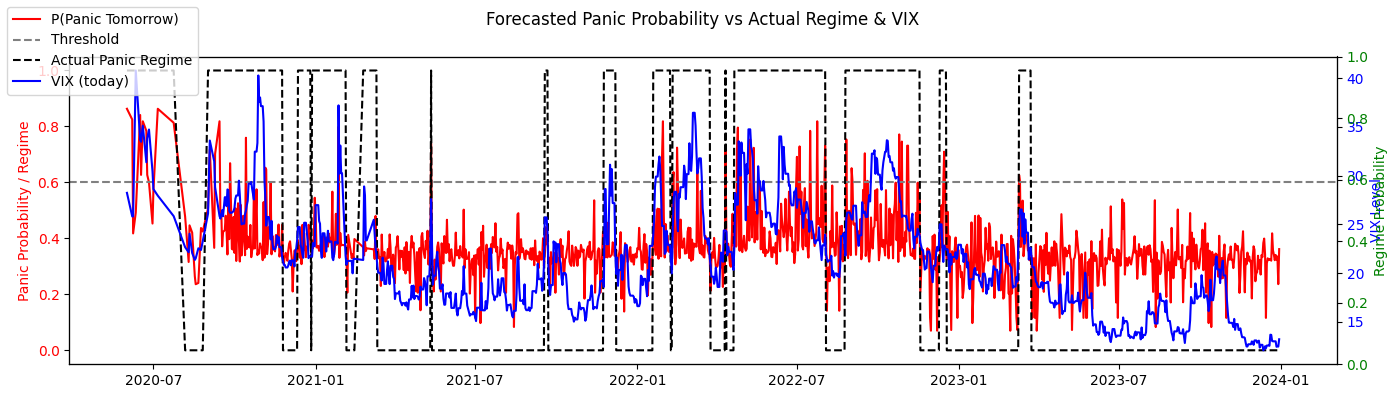

In [301]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.6, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax3 = ax1.twinx()
#ax3.plot(classification_df.index, classification_df['regime_t_raw'], label='Regime Probability', color='green')
ax3.set_ylabel("Regime Probability", color='green')
ax3.tick_params(axis='y', labelcolor='green')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


for each regime=1, we now get the set of days aferwards to see how vix behaves as soon as the model changes regime

In [302]:

# Train dataset (classification_df)
classification_df = macro_utils.identify_sustained_regimes_and_transitions(classification_df)

# Now you can apply it to the test data (test_df) in the same way:




In [303]:

# Usage Example:
result = macro_utils.transform_vix_data(classification_df, window=60)
vix_windows_df_train = result["vix_windows_df_train"]
regime_windows_df_train = result["regime_windows_df_train"]
vix_windows_past_df_train = result["vix_windows_past_df_train"]


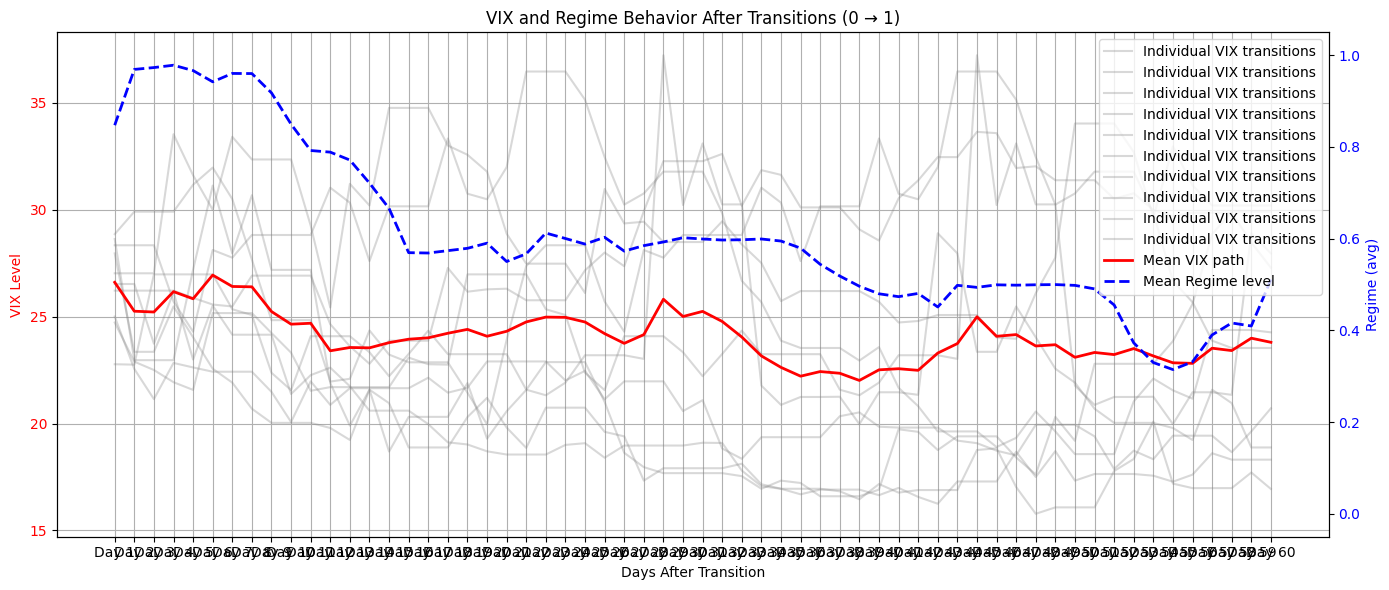

In [304]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_train.T, color="gray", alpha=0.3, label="Individual VIX transitions")
ax1.plot(vix_windows_df_train.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_train.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()



since some spikes happen quite some time after the regime switches, we will build a classifier for 0 (immediate) or 1 (delayed), then feed this into a model for vix level forecasting

In [305]:
vix_windows_df_train.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2020-12-13,24.719999,22.889999,22.500000,21.930000,21.570000,25.160000,25.160000,25.160000,24.230000,23.309999,...,20.870001,21.240000,21.240000,21.250000,19.969999,21.459999,21.459999,21.340000,28.889999,27.950001
2020-12-29,22.770000,22.750000,26.969999,26.969999,26.969999,26.969999,25.340000,25.070000,22.370001,21.559999,...,20.690001,20.030001,20.030001,20.030001,19.790001,19.230000,21.580000,20.950001,18.879999,18.879999
2021-02-25,27.950001,23.350000,23.350000,25.469999,24.030001,22.559999,21.910000,20.690001,20.030001,20.030001,...,17.639999,17.639999,17.639999,17.559999,17.280001,17.610001,18.610001,18.309999,18.309999,18.309999
2021-11-25,28.620001,22.959999,22.959999,22.959999,27.190001,31.120001,27.950001,30.670000,27.180000,27.180000,...,22.790001,22.790001,22.790001,22.790001,23.850000,25.590000,28.850000,29.900000,29.900000,29.900000
2022-01-20,28.850000,29.900000,29.900000,29.900000,31.160000,31.959999,30.490000,27.660000,24.830000,24.830000,...,31.770000,31.770000,31.770000,29.830000,26.670000,25.670000,23.870001,23.530001,23.530001,23.530001


In [306]:
df_delayed_spike_prob = macro_utils.clf_delayed_spike_prob(vix_windows_df_train, df_model, "vix_target")

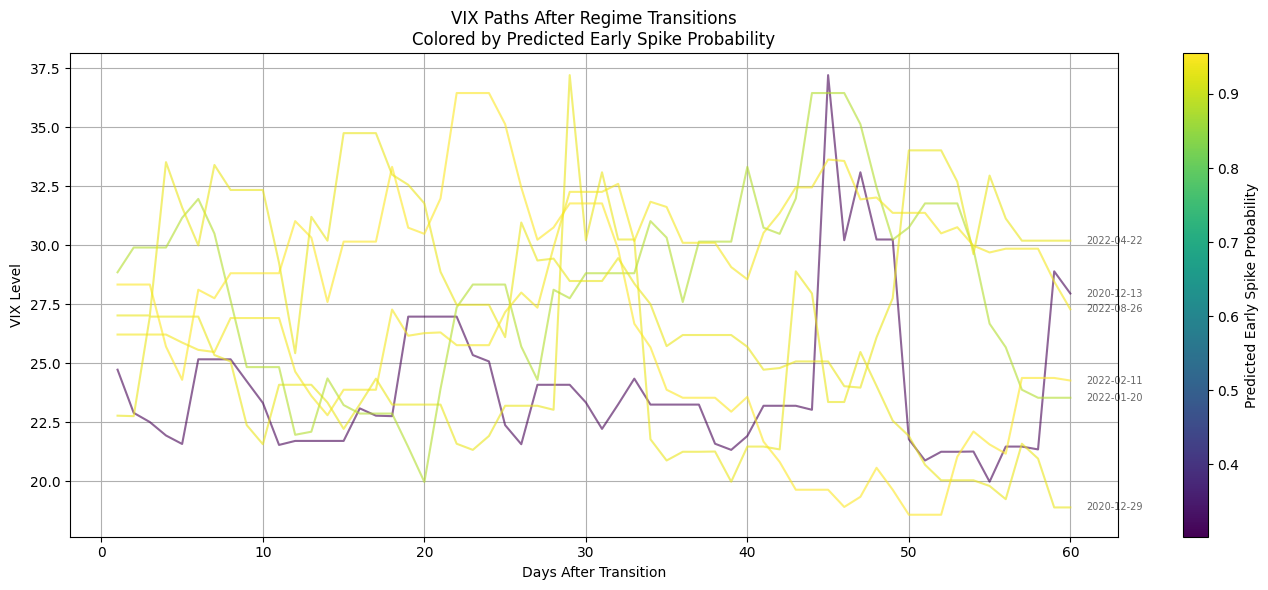

In [307]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [308]:
vix_windows_df_train

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2020-12-13,24.719999,22.889999,22.500000,21.930000,21.570000,25.160000,25.160000,25.160000,24.230000,23.309999,...,21.240000,21.240000,21.250000,19.969999,21.459999,21.459999,21.340000,28.889999,27.950001,0.3025
2020-12-29,22.770000,22.750000,26.969999,26.969999,26.969999,26.969999,25.340000,25.070000,22.370001,21.559999,...,20.030001,20.030001,20.030001,19.790001,19.230000,21.580000,20.950001,18.879999,18.879999,0.9325
2021-02-25,27.950001,23.350000,23.350000,25.469999,24.030001,22.559999,21.910000,20.690001,20.030001,20.030001,...,17.639999,17.639999,17.559999,17.280001,17.610001,18.610001,18.309999,18.309999,18.309999,NaN
2021-11-25,28.620001,22.959999,22.959999,22.959999,27.190001,31.120001,27.950001,30.670000,27.180000,27.180000,...,22.790001,22.790001,22.790001,23.850000,25.590000,28.850000,29.900000,29.900000,29.900000,NaN
2022-01-20,28.850000,29.900000,29.900000,29.900000,31.160000,31.959999,30.490000,27.660000,24.830000,24.830000,...,31.770000,31.770000,29.830000,26.670000,25.670000,23.870001,23.530001,23.530001,23.530001,0.8800
2022-02-11,28.330000,28.330000,28.330000,25.700001,24.290001,28.110001,27.750000,28.809999,28.809999,28.809999,...,18.570000,21.030001,22.100000,21.549999,21.160000,24.370001,24.370001,24.370001,24.260000,0.9550
2022-04-22,27.020000,27.020000,27.020000,33.520000,31.600000,29.990000,33.400002,32.340000,32.340000,32.340000,...,34.020000,32.689999,29.620001,32.950001,31.129999,30.190001,30.190001,30.190001,30.190001,0.9325
2022-08-26,26.209999,26.209999,26.209999,26.209999,25.870001,25.559999,25.469999,26.910000,26.910000,26.910000,...,30.500000,30.760000,29.980000,29.690001,29.850000,29.850000,29.850000,28.459999,27.280001,0.9425
2022-12-11,25.000000,22.549999,21.139999,22.830000,22.620001,22.420000,22.420000,22.420000,21.480000,20.070000,...,17.870001,18.730000,18.330000,19.430000,19.430000,19.430000,18.660000,19.629999,20.709999,NaN


In [309]:
model_long, model_sharp, y_pred_long, y_pred_sharp, sharp_rises_X, long_rises_X, sharp_rises_y, long_rises_y, long_rises_X_combined, long_rises_y_combined, sharp_rises_X_combined, sharp_rises_y_combined = macro_utils.linear_reg_models(vix_windows_df_train)

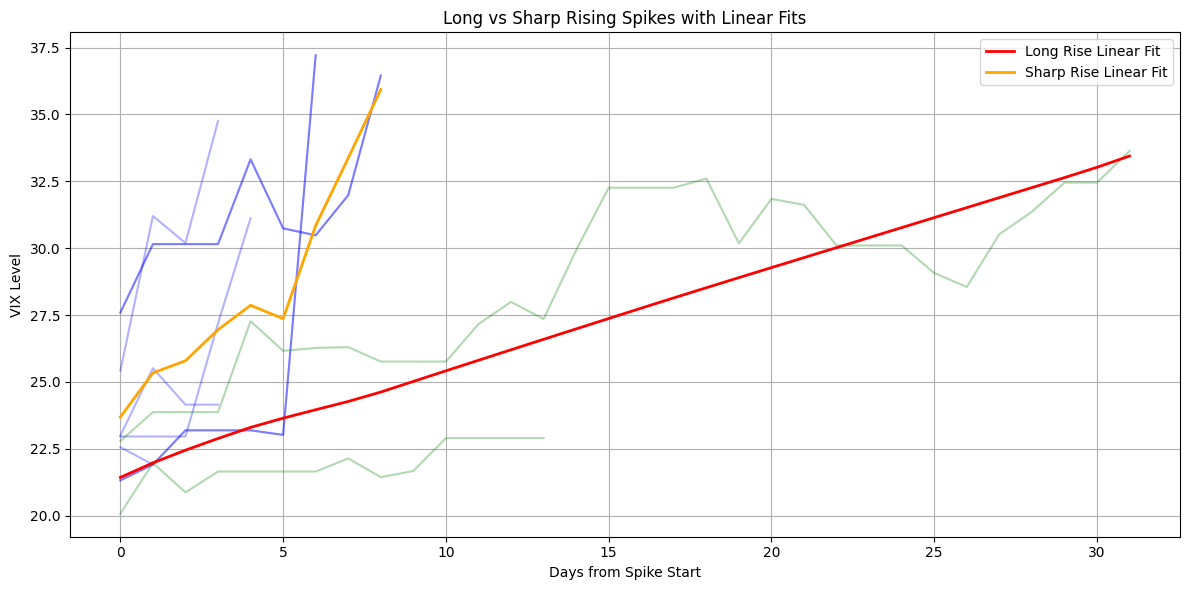

In [311]:
plt.figure(figsize=(12, 6))

# Plot sharp rises (blue)
for i in range(len(sharp_rises_X)):
    plt.plot(sharp_rises_X[i], sharp_rises_y[i], alpha=0.3, color='blue')

# Plot long rises (green)
for i in range(len(long_rises_X)):
    plt.plot(long_rises_X[i], long_rises_y[i], alpha=0.3, color='green')

# Plot long rise regression (red)
plt.plot(np.sort(long_rises_X_combined.flatten()), 
         model_long.predict(np.sort(long_rises_X_combined, axis=0)), 
         color='red', linewidth=2, label='Long Rise Linear Fit')

# Plot sharp rise regress ion (orange)
plt.plot(np.sort(sharp_rises_X_combined.flatten()), 
         model_sharp.predict(np.sort(sharp_rises_X_combined, axis=0)), 
         color='orange', linewidth=2, label='Sharp Rise Linear Fit')

plt.title("Long vs Sharp Rising Spikes with Linear Fits")
plt.xlabel("Days from Spike Start")
plt.ylabel("VIX Level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

because of randomness, we will just predict peak, half decay time, and rising time.

In [312]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news = train_df.copy()                       # original df you posted   # string/ts column → index
news = news.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        pos = f'{prefix}_pos_count'
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

        out[tot] = out[[pos, neg]].sum(axis=1).replace(0, 1)      # avoid ÷0
        out[f'{prefix}_pos_ratio'] = out[pos] / out[tot]
        out[f'{prefix}_neg_ratio'] = out[neg] / out[tot]
        out[f'{prefix}_range']     = out[f'{prefix}_max'] - out[f'{prefix}_min']

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats = engineer_news_feats(news)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats.index = pd.to_datetime(news_feats.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats.index.min(),
                          news_feats.index.max(),
                          freq='D')

news_dense = (
    news_feats
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_9552/1448525528.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()                 # carry last known sentiment forward


In [344]:
# ------------------------------------------------------------
# 3)  BUILD ARC‑LEVEL TABLE  (robust to missing news dates)
# ------------------------------------------------------------
records = []
for dt, row in vix_windows_df_train.iterrows():
    v = row[[f'Day {i}' for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc(v)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur            = peak_idx - start_idx
    decay_idx           = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life           = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest‑past news features --------
    try:
        feats_on_start = news_dense.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    records.append({
        "date_start": dt_norm,
        "peak_vix":  peak_val,
        "vix0":      start_val,
        "P_rel":     peak_val / start_val - 1,
        "T_up":      rise_dur,
        "T_half":    half_life,
        **feats_on_start
    })

arc_df = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)
print(arc_df.head(3).T)


arc_df shape: (10, 41)
date_start            2020-12-13  2020-12-29  2021-02-25
peak_vix               37.209999   37.209999       21.91
vix0                       21.32       21.32   22.559999
P_rel                    0.74531     0.74531   -0.028812
T_up                         6.0         6.0         1.0
T_half                      16.0        32.0        54.0
Unnamed: 0                 409.0       425.0       468.0
date                  2020-12-13  2020-12-29  2021-02-25
summary_mean           -0.245209   -0.010648    0.003575
summary_min            -0.964348   -0.964163   -0.973489
summary_max              0.79501    0.935617    0.947395
summary_pos_count           61.0       280.0        90.0
summary_neg_count           35.0        39.0        43.0
headline_mean          -0.231216    0.016138    -0.08323
headline_min           -0.970489   -0.952157   -0.971542
headline_max            0.788711    0.944653    0.946099
headline_pos_count          64.0       271.0        83.0
headline

In [345]:
arc_df = arc_df.drop(columns=['date', 'Unnamed: 0'], axis=1)

In [346]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

target_cols   = ["peak_vix", "T_up", "T_half"]
feature_cols  = arc_df.columns.difference(target_cols)

mlp_params = dict(
    hidden_layer_sizes=(2000, 1000, 500),
    activation="relu",
    learning_rate_init=3e-3,   # ↑ a bit
    alpha=1e-5,                # much weaker L2
    max_iter=3000,
    batch_size="auto",
    early_stopping=False,      # let it run full epochs
    random_state=42,
)

# ============================================================
# 1)  INPUT MATRICES & CV SPLIT
# ============================================================
X_full = arc_df[feature_cols].values
y_full = arc_df[target_cols].values
tscv   = TimeSeriesSplit(n_splits=5)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ============================================================
# 2)  TRAIN PER‑TARGET WITH y‑SCALING
# ============================================================
models, cv_mae = {}, {}

for i, col in enumerate(target_cols):
    y = y_full[:, i]

    # pipeline: X‑scaler → MLP, plus y‑scaler wrapper
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("mlp",     MLPRegressor(**mlp_params)),
    ])
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=StandardScaler()     # scales y
    )

    # walk‑forward CV
    cv = cross_validate(pipe, X_full, y,
                        cv=tscv,
                        scoring=mae_scorer,
                        n_jobs=-1,
                        return_train_score=False)
    cv_mae[col] = -cv["test_score"].mean()
    print(f"{col:8s} | MAE (5-fold): {cv_mae[col]:.3f}")

    # fit on all data & save
    pipe.fit(X_full, y)
    models[col] = pipe
    joblib.dump(pipe, f"mlp_{col}.pkl")

print("\nSaved pickled models:", [f"mlp_{c}.pkl" for c in target_cols])

# ============================================================
# 3)  HELPER FOR NEW PREDICTIONS
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    """
    row_df: DataFrame with one row and the same feature columns.
    returns dict {target: prediction}
    """
    preds = {col: float(models[col].predict(row_df[feature_cols].values))
             for col in target_cols}
    return preds

# Example:
# new_row = arc_df.iloc[[-1]]
# print(predict_new_arc(new_row))


peak_vix | MAE (5-fold): 3.254
T_up     | MAE (5-fold): 9.520
T_half   | MAE (5-fold): 17.673

Saved pickled models: ['mlp_peak_vix.pkl', 'mlp_T_up.pkl', 'mlp_T_half.pkl']


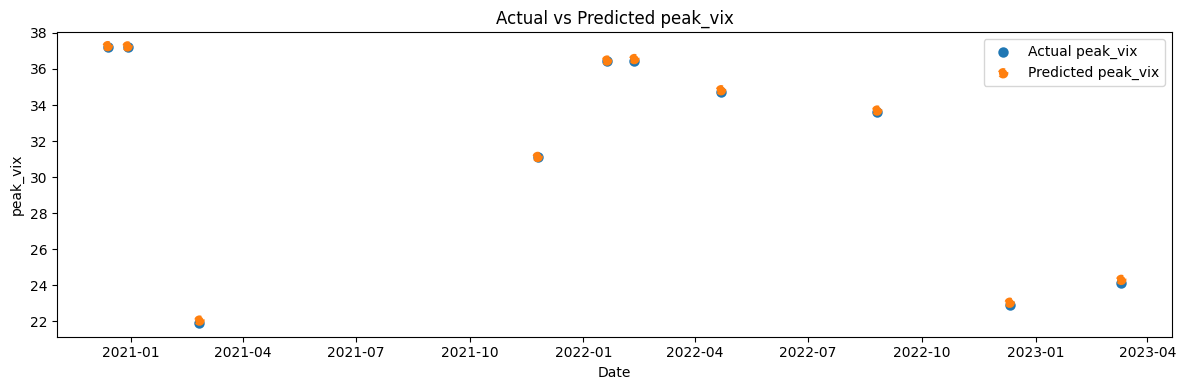

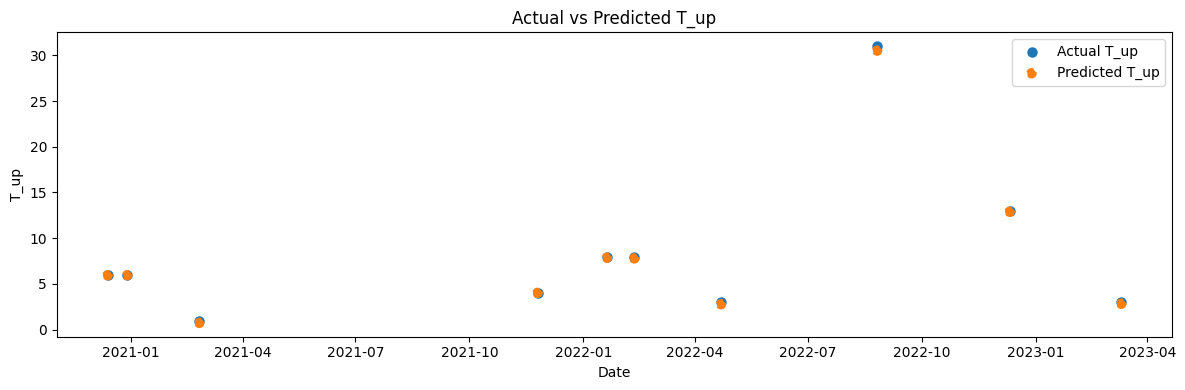

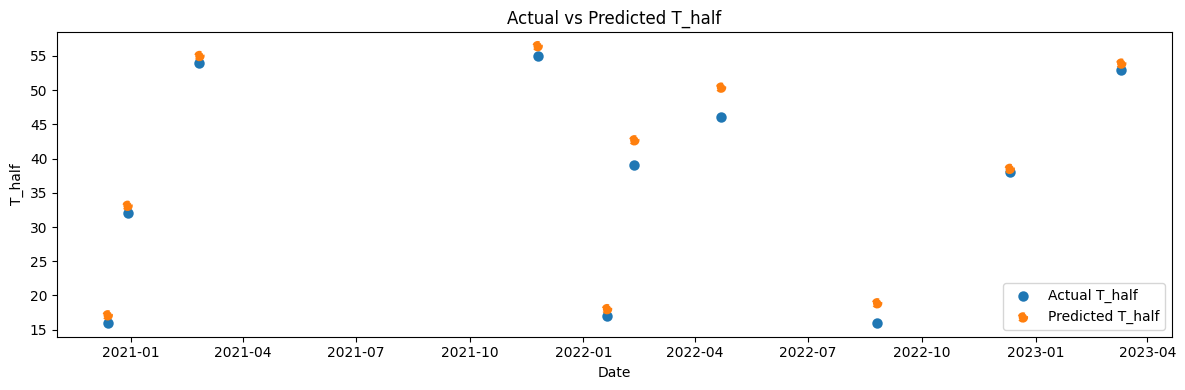

In [347]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])
X_full       = arc_df[feature_cols].values
dates        = arc_df.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}

for target, model in models.items():
    y_true = arc_df[target].values
    y_pred = model.predict(X_full)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Test Set on models (regime + panic probability)


In [319]:
vix_windows_df_train

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2020-12-13,24.719999,22.889999,22.500000,21.930000,21.570000,25.160000,25.160000,25.160000,24.230000,23.309999,...,21.240000,21.240000,21.250000,19.969999,21.459999,21.459999,21.340000,28.889999,27.950001,0.3025
2020-12-29,22.770000,22.750000,26.969999,26.969999,26.969999,26.969999,25.340000,25.070000,22.370001,21.559999,...,20.030001,20.030001,20.030001,19.790001,19.230000,21.580000,20.950001,18.879999,18.879999,0.9325
2021-02-25,27.950001,23.350000,23.350000,25.469999,24.030001,22.559999,21.910000,20.690001,20.030001,20.030001,...,17.639999,17.639999,17.559999,17.280001,17.610001,18.610001,18.309999,18.309999,18.309999,NaN
2021-11-25,28.620001,22.959999,22.959999,22.959999,27.190001,31.120001,27.950001,30.670000,27.180000,27.180000,...,22.790001,22.790001,22.790001,23.850000,25.590000,28.850000,29.900000,29.900000,29.900000,NaN
2022-01-20,28.850000,29.900000,29.900000,29.900000,31.160000,31.959999,30.490000,27.660000,24.830000,24.830000,...,31.770000,31.770000,29.830000,26.670000,25.670000,23.870001,23.530001,23.530001,23.530001,0.8800
2022-02-11,28.330000,28.330000,28.330000,25.700001,24.290001,28.110001,27.750000,28.809999,28.809999,28.809999,...,18.570000,21.030001,22.100000,21.549999,21.160000,24.370001,24.370001,24.370001,24.260000,0.9550
2022-04-22,27.020000,27.020000,27.020000,33.520000,31.600000,29.990000,33.400002,32.340000,32.340000,32.340000,...,34.020000,32.689999,29.620001,32.950001,31.129999,30.190001,30.190001,30.190001,30.190001,0.9325
2022-08-26,26.209999,26.209999,26.209999,26.209999,25.870001,25.559999,25.469999,26.910000,26.910000,26.910000,...,30.500000,30.760000,29.980000,29.690001,29.850000,29.850000,29.850000,28.459999,27.280001,0.9425
2022-12-11,25.000000,22.549999,21.139999,22.830000,22.620001,22.420000,22.420000,22.420000,21.480000,20.070000,...,17.870001,18.730000,18.330000,19.430000,19.430000,19.430000,18.660000,19.629999,20.709999,NaN


In [320]:
# 1. After fitting on training set
train_params = results.params

# 2. Prepare your test data
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)
test_df = test_df.dropna(subset=selected_features + ['vix_target_t+1']).copy()

X_test = test_df[selected_features]
y_test = test_df['vix_target_t+1']



# 3. Define same model on test data
model_test = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=2,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_test.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
test_df['regime_t'] = results_test.filtered_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.005 else 0)
test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
test_df['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

# 7. (Optional) Align as prediction for tomorrow
test_df['panic_prob_t+1'] = test_df['panic_prob_t+1'].shift(1)
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)




/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_9552/2412559088.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


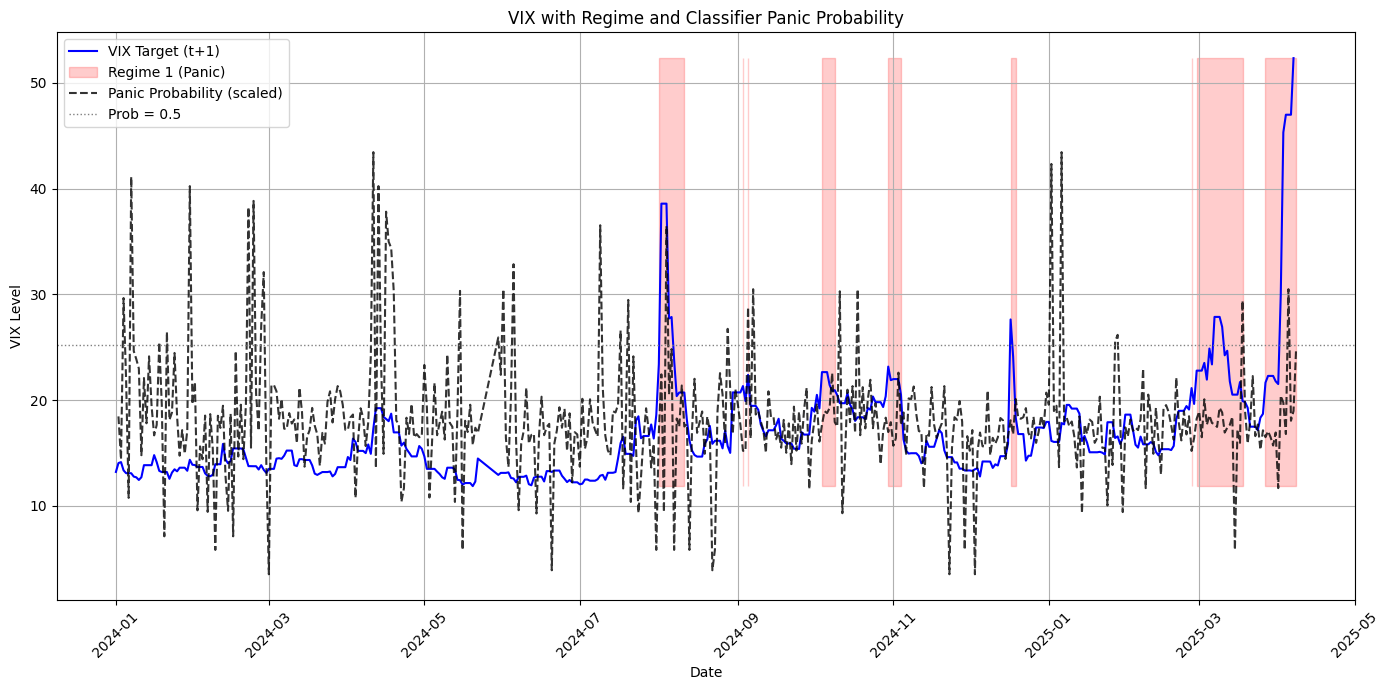

In [321]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_target_t+1"], label="VIX Target (t+1)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_target_t+1"].min(),
    test_df["vix_target_t+1"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target_t+1"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_target_t+1"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [349]:
test_df.head()

,Unnamed: 0,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,vix_7d_pct,vix_zscore,vix_target_t+1,regime_t,regime_t_raw,panic_prob_t+1,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,1497,2024-01-01,0.230589,-0.975066,0.928364,3,1,0.256950,-0.707050,0.939984,...,0.050955,1.024509,13.20,0,0.000126,NaN,1,False,NaN,False
2024-01-02,1498,2024-01-02,-0.051116,-0.972233,0.934338,15,10,-0.059740,-0.932877,0.941353,...,0.050955,1.005414,14.04,0,0.000008,0.366600,1,False,0.0,False
2024-01-03,1499,2024-01-03,-0.298161,-0.972755,0.943392,31,42,-0.345787,-0.969059,0.918668,...,0.120511,2.639696,14.13,0,0.000004,0.285530,1,False,0.0,False
2024-01-04,1500,2024-01-04,-0.376740,-0.974324,0.934698,17,34,-0.429220,-0.973915,0.948764,...,0.033650,2.435504,13.35,0,0.000002,0.589018,1,False,0.0,False
2024-01-05,1501,2024-01-05,-0.332922,-0.973382,0.931713,17,26,0.154316,-0.970470,0.945269,...,-0.021978,0.889861,13.08,0,0.000002,0.435412,1,False,0.0,False


In [350]:
classification_df_test = macro_utils.identify_sustained_regimes_and_transitions(test_df)

In [351]:
result = macro_utils.transform_vix_data(classification_df_test, window=60)
vix_windows_df_test = result["vix_windows_df_train"]
regime_windows_df_test = result["regime_windows_df_train"]
vix_windows_past_df_test = result["vix_windows_past_df_train"]

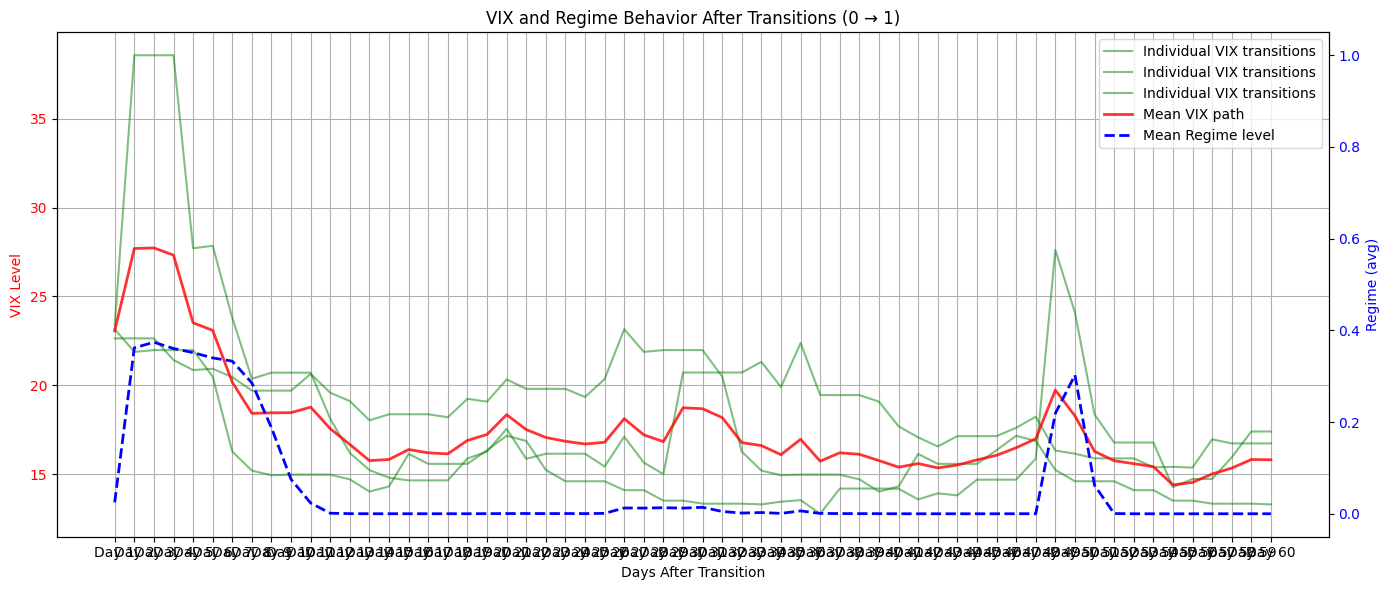

In [352]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_test.T, color="green", alpha=0.5, label="Individual VIX transitions")
ax1.plot(vix_windows_df_test.mean(axis=0).values, color="red",alpha=0.8, linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_test.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()



In [353]:
vix_windows_df_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-08-01,23.389999,38.570000,38.570000,38.57,27.709999,27.85,23.790001,20.370001,20.709999,20.709999,...,15.890000,15.890000,15.890000,15.390000,15.41,15.37,16.959999,16.73,16.73,16.73
2024-10-04,22.639999,22.639999,22.639999,21.42,20.860001,20.93,20.459999,19.700001,19.700001,19.700001,...,14.600000,14.600000,14.100000,14.100000,13.51,13.51,13.340000,13.34,13.34,13.30
2024-10-30,23.160000,21.879999,21.980000,21.98,21.980000,20.49,16.270000,15.200000,14.940000,14.970000,...,18.360001,16.780001,16.780001,16.780001,14.27,14.73,14.730000,15.95,17.40,17.40


In [354]:
df_delayed_spike_prob_test = macro_utils.clf_delayed_spike_prob(vix_windows_df_test, test_df, "vix_target")

In [355]:
vix_windows_df_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-08-01,23.389999,38.570000,38.570000,38.57,27.709999,27.85,23.790001,20.370001,20.709999,20.709999,...,15.890000,15.890000,15.390000,15.41,15.37,16.959999,16.73,16.73,16.73,0.7475
2024-10-04,22.639999,22.639999,22.639999,21.42,20.860001,20.93,20.459999,19.700001,19.700001,19.700001,...,14.600000,14.100000,14.100000,13.51,13.51,13.340000,13.34,13.34,13.30,NaN
2024-10-30,23.160000,21.879999,21.980000,21.98,21.980000,20.49,16.270000,15.200000,14.940000,14.970000,...,16.780001,16.780001,16.780001,14.27,14.73,14.730000,15.95,17.40,17.40,0.2750


In [356]:
df_delayed_spike_prob_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-08-01,23.389999,38.570000,38.570000,38.57,27.709999,27.85,23.790001,20.370001,20.709999,20.709999,...,15.890000,15.890000,15.390000,15.41,15.37,16.959999,16.73,16.73,16.73,0.7475
2024-10-04,22.639999,22.639999,22.639999,21.42,20.860001,20.93,20.459999,19.700001,19.700001,19.700001,...,14.600000,14.100000,14.100000,13.51,13.51,13.340000,13.34,13.34,13.30,NaN
2024-10-30,23.160000,21.879999,21.980000,21.98,21.980000,20.49,16.270000,15.200000,14.940000,14.970000,...,16.780001,16.780001,16.780001,14.27,14.73,14.730000,15.95,17.40,17.40,0.2750


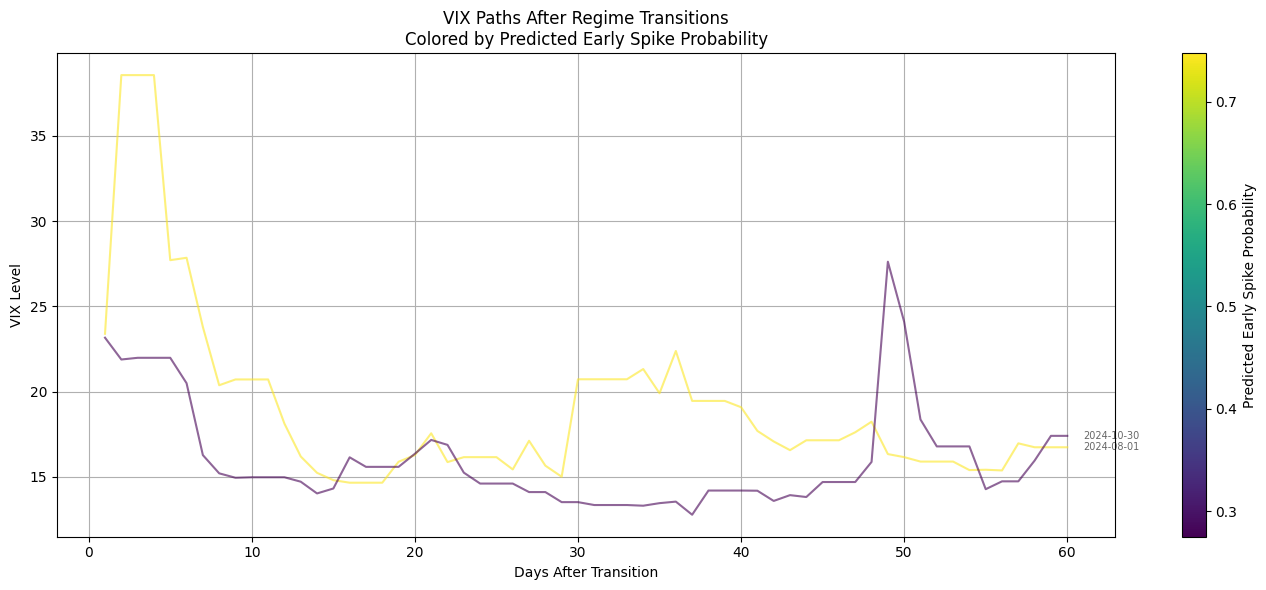

In [357]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob_test.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [358]:
vix_windows_df_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-08-01,23.389999,38.570000,38.570000,38.57,27.709999,27.85,23.790001,20.370001,20.709999,20.709999,...,15.890000,15.890000,15.390000,15.41,15.37,16.959999,16.73,16.73,16.73,0.7475
2024-10-04,22.639999,22.639999,22.639999,21.42,20.860001,20.93,20.459999,19.700001,19.700001,19.700001,...,14.600000,14.100000,14.100000,13.51,13.51,13.340000,13.34,13.34,13.30,NaN
2024-10-30,23.160000,21.879999,21.980000,21.98,21.980000,20.49,16.270000,15.200000,14.940000,14.970000,...,16.780001,16.780001,16.780001,14.27,14.73,14.730000,15.95,17.40,17.40,0.2750


In [359]:
model_long_test, model_sharp_test, y_pred_long_test, y_pred_sharp_test, sharp_rises_X_test, long_rises_X_test, sharp_rises_y_test, long_rises_y_test, long_rises_X_combined_test, long_rises_y_combined_test, sharp_rises_X_combined_test, sharp_rises_y_combined_test = macro_utils.linear_reg_models(vix_windows_df_test)


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [360]:
y_pred_sharp_test = model_sharp.predict(sharp_rises_X_combined_test)

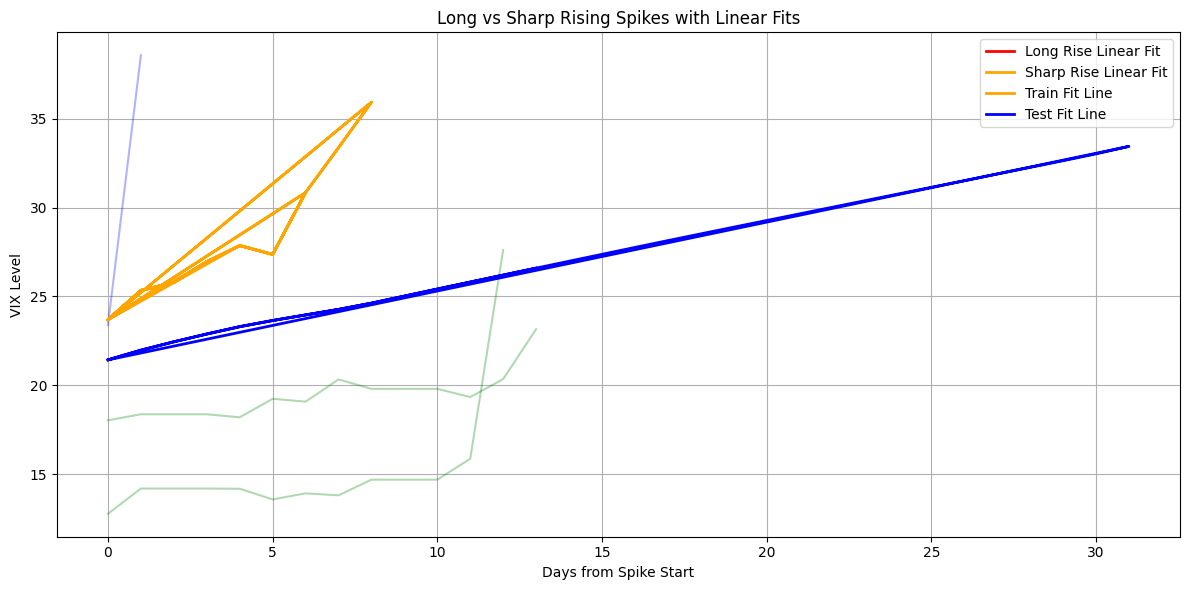

In [362]:
plt.figure(figsize=(12, 6))

# Plot sharp rises (blue)
for i in range(len(sharp_rises_X_test)):
    plt.plot(sharp_rises_X_test[i], sharp_rises_y_test[i], alpha=0.3, color='blue')

# Plot long rises (green)
for i in range(len(long_rises_X_test)):
    plt.plot(long_rises_X_test[i], long_rises_y_test[i], alpha=0.3, color='green')

# Plot long rise regression (red)
plt.plot(np.sort(long_rises_X_combined_test.flatten()), 
         model_long.predict(np.sort(long_rises_X_combined_test, axis=0)), 
         color='red', linewidth=2, label='Long Rise Linear Fit')

# Plot sharp rise regress ion (orange)
plt.plot(np.sort(sharp_rises_X_combined_test.flatten()), 
         model_sharp.predict(np.sort(sharp_rises_X_combined_test, axis=0)), 
         color='orange', linewidth=2, label='Sharp Rise Linear Fit')



# During test-time visualization
plt.plot(sharp_rises_X_combined.flatten(), y_pred_sharp, color='orange', linewidth=2, label='Train Fit Line')
plt.plot(long_rises_X_combined.flatten(), y_pred_long, color='blue', linewidth=2, label='Test Fit Line')



plt.title("Long vs Sharp Rising Spikes with Linear Fits")
plt.xlabel("Days from Spike Start")
plt.ylabel("VIX Level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [363]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = test_df.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        pos = f'{prefix}_pos_count'
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

        out[tot] = out[[pos, neg]].sum(axis=1).replace(0, 1)      # avoid ÷0
        out[f'{prefix}_pos_ratio'] = out[pos] / out[tot]
        out[f'{prefix}_neg_ratio'] = out[neg] / out[tot]
        out[f'{prefix}_range']     = out[f'{prefix}_max'] - out[f'{prefix}_min']

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_test = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_test.index = pd.to_datetime(news_feats_test.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_test.index.min(),
                          news_feats_test.index.max(),
                          freq='D')

news_dense_test = (
    news_feats_test
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_9552/1853403672.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()                 # carry last known sentiment forward


In [364]:
# ------------------------------------------------------------
# 3)  BUILD ARC‑LEVEL TABLE  (robust to missing news dates)
# ------------------------------------------------------------
records = []
for dt, row in vix_windows_df_test.iterrows():
    v = row[[f'Day {i}' for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc(v)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur            = peak_idx - start_idx
    decay_idx           = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life           = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest‑past news features --------
    try:
        feats_on_start = news_dense.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    records.append({
        "date_start": dt_norm,
        "peak_vix":  peak_val,
        "vix0":      start_val,
        "P_rel":     peak_val / start_val - 1,
        "T_up":      rise_dur,
        "T_half":    half_life,
        **feats_on_start
    })

arc_df_test = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)
print(arc_df_test.head(3).T)


arc_df shape: (10, 39)
date_start            2024-08-01  2024-10-04  2024-10-30
peak_vix                   38.57       23.16   27.620001
vix0                   23.389999   18.030001       12.77
P_rel                   0.648995    0.284526    1.162882
T_up                         1.0        13.0        12.0
T_half                      10.0        34.0        12.0
Unnamed: 0                1496.0      1496.0      1496.0
date                  2023-12-31  2023-12-31  2023-12-31
summary_mean            -0.08967    -0.08967    -0.08967
summary_min            -0.974704   -0.974704   -0.974704
summary_max             0.945365    0.945365    0.945365
summary_pos_count          109.0       109.0       109.0
summary_neg_count           50.0        50.0        50.0
headline_mean          -0.145494   -0.145494   -0.145494
headline_min           -0.972214   -0.972214   -0.972214
headline_max            0.946728    0.946728    0.946728
headline_pos_count         107.0       107.0       107.0
headline

In [365]:
arc_df_test = arc_df_test.drop(columns=['date', 'Unnamed: 0'], axis=1)

In [366]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

target_cols   = ["peak_vix", "T_up", "T_half"]
feature_cols  = arc_df_test.columns.difference(target_cols)

mlp_params = dict(
    hidden_layer_sizes=(2000, 1000, 500),
    activation="relu",
    learning_rate_init=3e-3,   # ↑ a bit
    alpha=1e-5,                # much weaker L2
    max_iter=3000,
    batch_size="auto",
    early_stopping=False,      # let it run full epochs
    random_state=42,
)

# ============================================================
# 1)  INPUT MATRICES & CV SPLIT
# ============================================================
X_full = arc_df_test[feature_cols].values
y_full = arc_df_test[target_cols].values
tscv   = TimeSeriesSplit(n_splits=2)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ============================================================
# 2)  TRAIN PER‑TARGET WITH y‑SCALING
# ============================================================
models, cv_mae = {}, {}

for i, col in enumerate(target_cols):
    y = y_full[:, i]

    # pipeline: X‑scaler → MLP, plus y‑scaler wrapper
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("mlp",     MLPRegressor(**mlp_params)),
    ])
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=StandardScaler()     # scales y
    )

    # walk‑forward CV
    cv = cross_validate(pipe, X_full, y,
                        cv=tscv,
                        scoring=mae_scorer,
                        n_jobs=-1,
                        return_train_score=False)
    cv_mae[col] = -cv["test_score"].mean()
    print(f"{col:8s} | MAE (5-fold): {cv_mae[col]:.3f}")

    # fit on all data & save
    pipe.fit(X_full, y)
    models[col] = pipe
    joblib.dump(pipe, f"mlp_{col}_test.pkl")

print("\nSaved pickled models:", [f"mlp_{c}_test.pkl" for c in target_cols])

# ============================================================
# 3)  HELPER FOR NEW PREDICTIONS
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    """
    row_df: DataFrame with one row and the same feature columns.
    returns dict {target: prediction}
    """
    preds = {col: float(models[col].predict(row_df[feature_cols].values))
             for col in target_cols}
    return preds

# Example:
# new_row = arc_df.iloc[[-1]]
# print(predict_new_arc(new_row))


peak_vix | MAE (5-fold): 10.732
T_up     | MAE (5-fold): 13.083
T_half   | MAE (5-fold): 16.163

Saved pickled models: ['mlp_peak_vix_test.pkl', 'mlp_T_up_test.pkl', 'mlp_T_half_test.pkl']


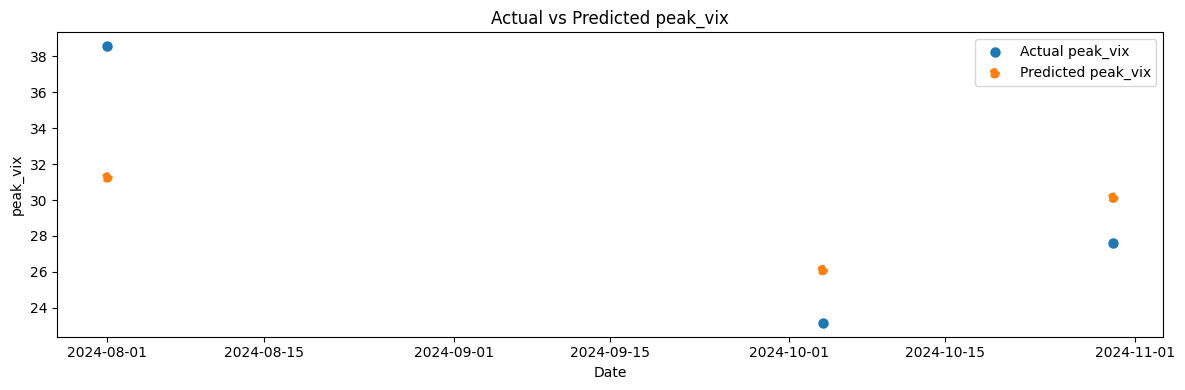

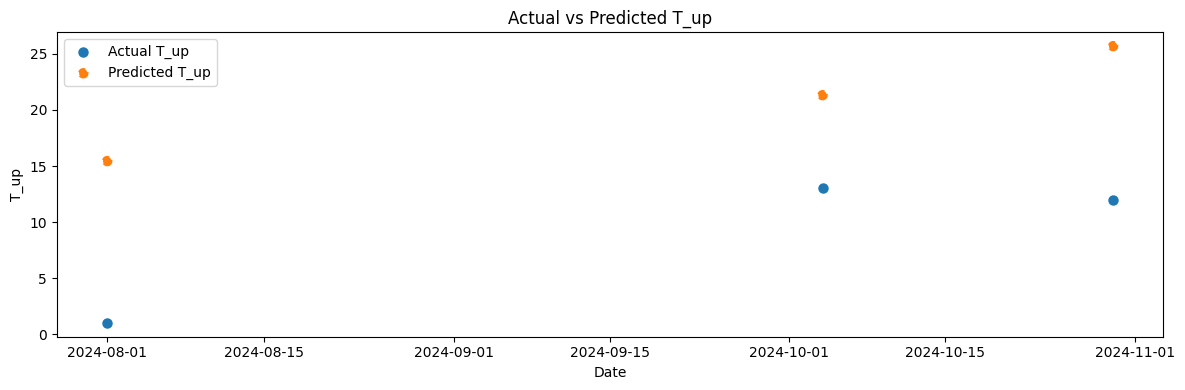

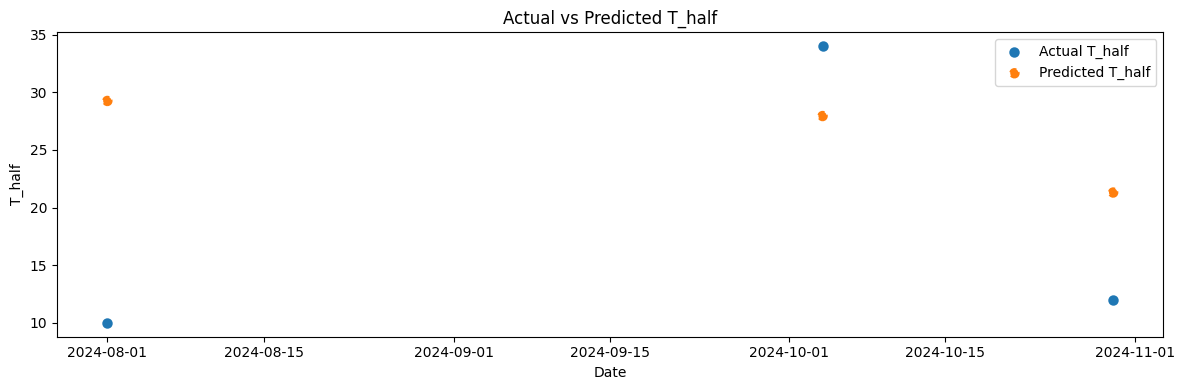

In [367]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df_test.columns.difference(["peak_vix", "T_up", "T_half"])
X_full_test       = arc_df_test[feature_cols].values
dates        = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Markov Switching Auto Regressive model

In [214]:
regime_0_df = df_model[df_model['regime_t'] == 0]
regime_1_df = df_model[df_model['regime_t'] == 1]

In [215]:
from statsmodels.tsa.ar_model import AutoReg

ar_regime_0 = AutoReg(regime_0_df['vix_target'], lags=1, trend='c').fit()
ar_regime_1 = AutoReg(regime_1_df['vix_target'], lags=1, trend='c').fit()

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [216]:
import numpy as np
def forecast_vix_autoreg(current_vix, current_regime):
    phi = ar_regime_0.params if current_regime == 0 else ar_regime_1.params
    forecast = phi['const'] + phi['vix_target.L1'] * current_vix
    return forecast

In [217]:
sigma_0 = np.std(ar_regime_0.resid)
sigma_1 = np.std(ar_regime_1.resid)

phi_0 = ar_regime_0.params
phi_1 = ar_regime_1.params

transition_matrix_forecast = transition_matrix #from our first model

initial_regime = df_model['regime_t'].iloc[-1]  # last predicted regime


In [218]:
first_panic = test_df[test_df['regime_t'] == 1].iloc[0]
print(first_panic['vix_target'])


18.59000015258789


In [219]:
# Step 1: Detect regime transitions (0 → 1)
test_df['regime_t-1'] = test_df['regime_t'].shift(1)
test_df['is_transition'] = (test_df['regime_t-1'] == 0) & (test_df['regime_t'] == 1)



In [220]:
test_df[test_df['is_transition']]

,Unnamed: 0,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,vix_target_t+1,regime_t,panic_prob_t+1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-08-01,1703,2024-08-01,-0.292869,-0.973897,0.947609,65,99,-0.278619,-0.974209,0.950001,...,-0.974053,-34,1,0.283840,1.867475,23.389999,1,0.477831,0.0,True
2024-09-03,1736,2024-09-03,-0.033295,-0.969301,0.948438,106,54,-0.090644,-0.966677,0.939915,...,-0.967989,52,0,0.414334,0.340104,21.320000,1,0.489463,0.0,True
2024-09-05,1738,2024-09-05,-0.127234,-0.968873,0.949641,210,91,-0.040936,-0.975435,0.943705,...,-0.972154,119,0,0.223110,0.550898,22.379999,1,0.514686,0.0,True
2024-10-04,1767,2024-10-04,-0.161758,-0.974880,0.956488,25,24,-0.179731,-0.966917,0.948299,...,-0.970898,1,0,0.176362,0.892619,22.639999,1,0.466187,0.0,True
2024-10-30,1793,2024-10-30,-0.023059,-0.976818,0.955613,42,27,-0.070288,-0.969683,0.952119,...,-0.973251,15,0,-0.014050,0.358336,23.160000,1,0.493824,0.0,True
2024-12-17,1841,2024-12-17,-0.200720,-0.973212,0.951735,128,95,-0.080458,-0.973030,0.951784,...,-0.973121,33,0,0.189655,1.374896,27.620001,1,0.493454,0.0,True
2025-02-28,1914,2025-02-28,-0.178687,-0.975512,0.954631,75,60,-0.157563,-0.966205,0.952781,...,-0.970858,15,0,0.300000,1.494880,22.780001,1,0.475647,0.0,True
2025-03-27,1941,2025-03-27,-0.116046,-0.972738,0.951299,190,97,-0.160304,-0.974677,0.947820,...,-0.973707,93,0,-0.228642,-0.946713,21.650000,1,0.472414,0.0,True


In [221]:
# Step 2: Store 15-day windows of VIX after each transition
window = 5
vix_windows = []

for idx in test_df[test_df['is_transition']].index:
    # Get position of the index
    loc = test_df.index.get_loc(idx)
    # Slice the 15 days following the transition (including the day itself)
    vix_slice = test_df.iloc[loc:loc + window]['vix_target_t+1'].values
    # Only store windows with full length (some at end of data may be shorter)
    if len(vix_slice) == window:
        vix_windows.append(vix_slice)

# Step 3: Convert to DataFrame for analysis/plotting
vix_windows_df = pd.DataFrame(vix_windows)
vix_windows_df.index.name = "Transition #"
vix_windows_df.columns = [f"Day {i}" for i in range(1, window + 1)]

In [222]:
vix_windows_df

,Day 1,Day 2,Day 3,Day 4,Day 5
Transition #,,,,,
0,23.389999,38.570000,38.570000,38.570000,27.709999
1,21.320000,19.900000,22.379999,19.450001,19.450001
2,22.379999,19.450001,19.450001,19.450001,19.080000
3,22.639999,22.639999,22.639999,21.420000,20.860001
4,23.160000,21.879999,21.980000,21.980000,21.980000
5,27.620001,24.090000,18.360001,16.780001,16.780001
6,22.780001,22.780001,22.780001,23.510000,21.930000
7,21.650000,22.280001,22.280001,22.280001,21.770000


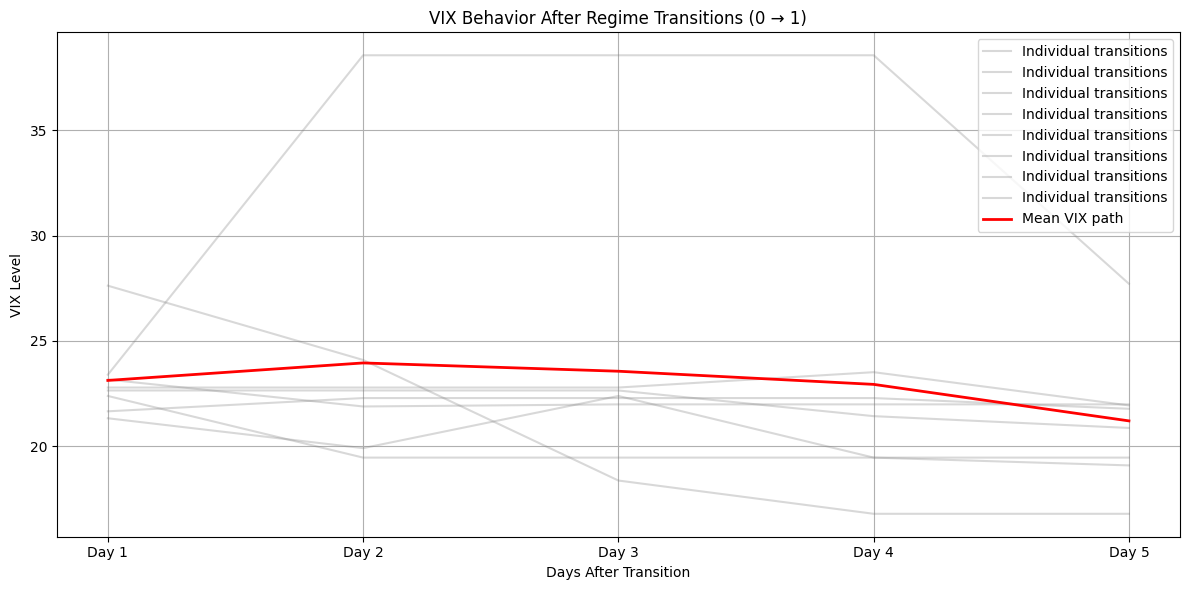

In [223]:
plt.figure(figsize=(12, 6))
plt.plot(vix_windows_df.T, color="gray", alpha=0.3, label="Individual transitions")
plt.plot(vix_windows_df.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")

plt.title("VIX Behavior After Regime Transitions (0 → 1)")
plt.xlabel("Days After Transition")
plt.ylabel("VIX Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/794786639.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_0[phi_0.index.str.contains('L1')][0]
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/794786639.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_1[phi_1.index.str.contains('L1')][0]


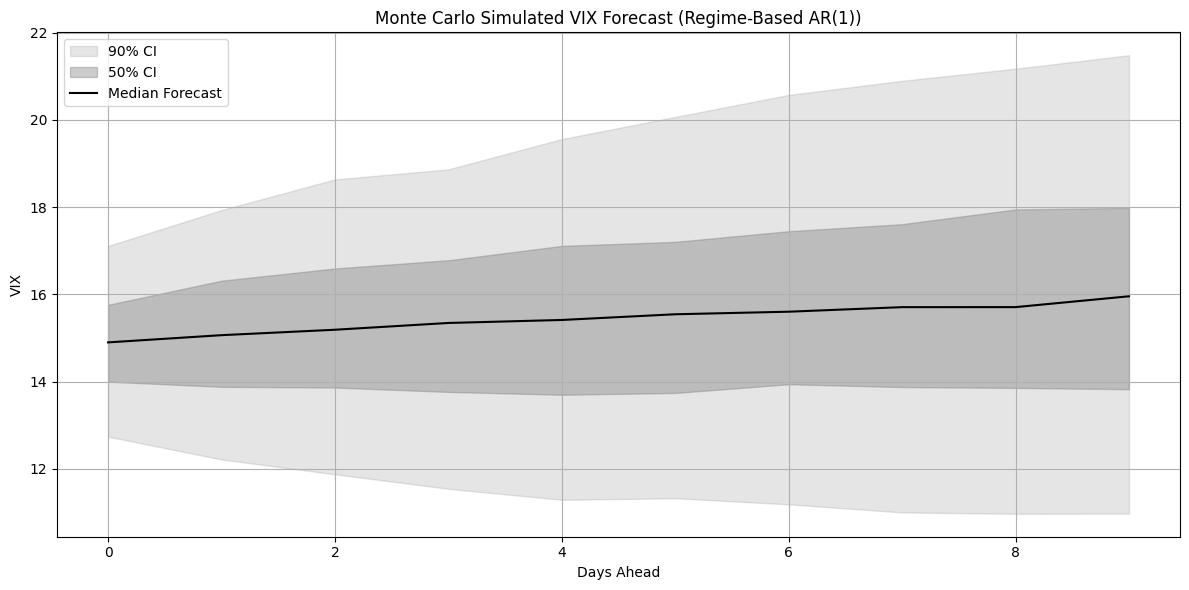

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_vix_paths_ar(n_days=30, n_paths=1000, start_val=20, start_regime=0,
                          phi_0=None, phi_1=None,
                          sigma_0=1.0, sigma_1=1.0,
                          transition_matrix=None):
    paths = np.zeros((n_paths, n_days))
    regimes = np.zeros((n_paths, n_days), dtype=int)

    for i in range(n_paths):
        vix = start_val
        regime = start_regime

        for t in range(n_days):
            # Transition to next regime
            regime = np.random.choice([0, 1], p=transition_matrix[regime])
            regimes[i, t] = regime

            if regime == 0:
                const = phi_0['const']
                phi = phi_0[phi_0.index.str.contains('L1')][0]
                shock = np.random.normal(0, sigma_0)
                vix = const + phi * vix + shock
            else:
                const = phi_1['const']
                phi = phi_1[phi_1.index.str.contains('L1')][0]
                shock = np.random.normal(0, sigma_1)
                vix = const + phi * vix + shock

            paths[i, t] = vix

    return paths, regimes

# === Run the simulation ===
first_panic = test_df[test_df['regime_t'] == 1].iloc[0]
first_panic = first_panic['vix_target']
#start_vix = test_df['vix_target_t+1'].iloc[0]
sim_paths, sim_regimes = simulate_vix_paths_ar(
    n_days=10,
    n_paths=1000,
    start_val=first_panic,
    start_regime=initial_regime,
    phi_0=phi_0,
    phi_1=phi_1,
    sigma_0=sigma_0,
    sigma_1=sigma_1,
    transition_matrix=transition_matrix_forecast
)

# === Plot fan chart ===
percentiles = np.percentile(sim_paths, [5, 25, 50, 75, 95], axis=0)
days = np.arange(sim_paths.shape[1])

plt.figure(figsize=(12, 6))
plt.fill_between(days, percentiles[0], percentiles[-1], color='gray', alpha=0.2, label='90% CI')
plt.fill_between(days, percentiles[1], percentiles[-2], color='gray', alpha=0.4, label='50% CI')
plt.plot(days, percentiles[2], color='black', label='Median Forecast')
plt.title("Monte Carlo Simulated VIX Forecast (Regime-Based AR(1))")
plt.xlabel("Days Ahead")
plt.ylabel("VIX")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
forecast_horizon = 30
expected_paths = []

# Loop through each test point where regime == 1
for idx in range(len(test_df) - forecast_horizon):
    row = test_df.iloc[idx]
    if row['regime_t'] == 1:
        vix_start = row['vix_target_t+1']
        regime_start = row['regime_t']

        # Simulate forecasts from this point
        sim_paths, _ = simulate_vix_paths_ar(
            n_days=forecast_horizon,
            n_paths=1000,
            start_val=vix_start,
            start_regime=regime_start,
            phi_0=phi_0,
            phi_1=phi_1,
            sigma_0=sigma_0,
            sigma_1=sigma_1,
            transition_matrix=transition_matrix_forecast
        )

        # Use expected value (mean forecast) — or replace with np.median(...) if preferred
        expected_path = np.mean(sim_paths, axis=0)

        # Align with index
        future_dates = test_df.index[idx:idx + forecast_horizon]
        if len(future_dates) == forecast_horizon:
            expected_paths.append((future_dates, expected_path))

# === Plot ===
plt.figure(figsize=(14, 7))

# Plot actual VIX
plt.plot(test_df.index, test_df["vix_target_t+1"], label="VIX Target (t+1)", color="blue")

# Highlight panic regime areas
plt.fill_between(
    test_df.index,
    test_df["vix_target_t+1"].min(),
    test_df["vix_target_t+1"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# Plot scaled panic probability
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target_t+1"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)
plt.axhline(y=0.5 * (test_df["vix_target_t+1"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Plot expected forecast paths (mean or median)
for dates, path in expected_paths:
    plt.plot(dates, path, color="green", alpha=0.7, linewidth=1.8, label="Expected VIX Forecast" if 'Expected VIX Forecast' not in plt.gca().get_legend_handles_labels()[1] else "")

# Finalize
plt.title("Expected VIX Forecasts During Panic Regimes")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/1077054220.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_1[phi_1.index.str.contains('L1')][0]
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/1077054220.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_0[phi_0.index.str.contains('L1')][0]


KeyboardInterrupt: 

# XGboost model

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



